# __Image classification using logistic regression__

Classification of microscopic images <br>
Two classes: <br>
A - field with no colony <br>
B - field with colony

For model training the folder structure should be: <br>
    data folder: <br>
- A subfolder - tiff images with no colonies (negative class) <br>
- B subfolder - tiff images with colonies (positive class) <br>

In [1]:
import os
from PIL import Image
# data 
import numpy as np
import pandas as pd
# ML packages
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, recall_score
import joblib
# visualization
from skimage import filters
import matplotlib.pyplot as plt

In [2]:
# Global variables
TARGET_SIZE = (224, 224) # must equal with the target size of unstacking workflow!
THRESHOLD = 0.4 # threshold for binary classification
# regularization
C=0.001

In [3]:
def prepare_data(base_folder, target_size=TARGET_SIZE, normalize=True):
    """
    Prepare image data and labels for logistic regression from folders of JPG images.
    
    Args:
    base_folder (str): Path to the base folder containing 'A' and 'B' subfolders.
    target_size (tuple): Desired size of the output images (height, width).
    normalize (bool): If True, normalize pixel values to [0, 1].
    
    Returns:
    tuple: (X, y) where X is a numpy array of flattened image data and y is a numpy array of labels.
    """
    
    # Check if base folder exists
    if not os.path.exists(base_folder):
        raise FileNotFoundError(f"The base folder {base_folder} does not exist.")
    
    # Check if 'A' and 'B' subfolders exist
    folder_a = os.path.join(base_folder, 'A')
    folder_b = os.path.join(base_folder, 'B')
    if not os.path.exists(folder_a) or not os.path.exists(folder_b):
        raise FileNotFoundError(f"Both 'A' and 'B' subfolders must exist in {base_folder}")
    
    X = []
    y = []
    
    # Process images in folder A (class 0)
    for filename in os.listdir(folder_a):
        if filename.lower().endswith(('.jpg', '.jpeg')):
            X.append(process_image(os.path.join(folder_a, filename), target_size, normalize))
            y.append(0)
    
    # Process images in folder B (class 1)
    for filename in os.listdir(folder_b):
        if filename.lower().endswith(('.jpg', '.jpeg')):
            X.append(process_image(os.path.join(folder_b, filename), target_size, normalize))
            y.append(1)
    
    return np.array(X), np.array(y)

def process_image(file_path, target_size, normalize=True, plot_steps=False):
    """
    Process a single image file with background normalization and conversion to grayscale.
    
    Args:
    file_path (str): Path to the image file.
    target_size (tuple): Desired size of the output image (height, width).
    normalize (bool): If True, normalize pixel values to [0, 1].
    plot_steps (bool): If True, show intermediate processing steps.
    
    Returns:
    numpy.ndarray: Flattened grayscale image array with normalized background.
    """
    with Image.open(file_path) as img:
        # Convert to grayscale
        img = img.convert('L')
        
        # Convert to numpy array for processing
        img_array = np.array(img, dtype=np.float32)
        
        # Calculate background mask using Otsu's method
        thresh = filters.threshold_otsu(img_array)
        background_mask = img_array < thresh
        
        # Calculate background statistics
        background_mean = np.mean(img_array[background_mask])
        background_std = np.std(img_array[background_mask])
        
        # Normalize the image based on background
        normalized_img = (img_array - background_mean) / (background_std + 1e-10)
        
        # Scale to 0-1 range
        normalized_img = (normalized_img - normalized_img.min()) / (normalized_img.max() - normalized_img.min())
        
        if normalize:
            # Additional normalization if requested
            normalized_img = normalized_img.astype(np.float32)
        else:
            # Convert to 0-255 range if normalization not requested
            normalized_img = (normalized_img * 255).astype(np.uint8)
        
        # Convert back to PIL Image for resizing
        normalized_pil = Image.fromarray(
            (normalized_img * 255).astype(np.uint8) if normalize else normalized_img
        )
        
        # Resize the image
        resized_img = normalized_pil.resize(target_size, Image.Resampling.LANCZOS)
        
        # Convert back to numpy array
        final_array = np.array(resized_img)
        
        if normalize:
            final_array = final_array.astype(np.float32) / 255.0
        
        if plot_steps:
            fig, axes = plt.subplots(1, 4, figsize=(20, 5))
            
            # Original image
            axes[0].imshow(img_array, cmap='gray')
            axes[0].set_title(f'Original\nBg mean={background_mean:.1f}\nBg std={background_std:.1f}')
            axes[0].axis('off')
            
            # Background mask
            axes[1].imshow(background_mask, cmap='gray')
            axes[1].set_title('Background Mask')
            axes[1].axis('off')
            
            # Normalized image before resize
            axes[2].imshow(normalized_img, cmap='gray')
            axes[2].set_title('Normalized')
            axes[2].axis('off')
            
            # Final resized image
            axes[3].imshow(final_array, cmap='gray')
            axes[3].set_title(f'Final ({target_size[0]}x{target_size[1]})')
            axes[3].axis('off')
            
            plt.tight_layout()
            plt.show()

        print(file_path)
        # Flatten the image
        return final_array.reshape(-1)


__Logistic Regression__

_train_logistic_regression_ function performs the Logistic regression classification.  

In [4]:
def train_logistic_regression(X, y, test_size=0.2, random_state=42, C=C):
    """
    Train a logistic regression model, evaluate it, and save the model.

    Args:
    X (np.array): Feature matrix (output from prepare_data function)
    y (np.array): Target vector (output from prepare_data function)
    test_size (float): Proportion of the dataset to include in the test split
    random_state (int): Random state for reproducibility
    C (float): Inverse of regularization strength; must be a positive float

    Returns:
    tuple: (pipeline, accuracy, auroc)
    """

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Create a pipeline with StandardScaler and LogisticRegression
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(C=C, random_state=random_state))
    ])

    # Fit the pipeline
    pipeline.fit(X_train, y_train)
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='recall')
    print(f"Cross-validation scores: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    auroc = roc_auc_score(y_test, y_pred_proba)
    sens = recall_score(y_test, y_pred, average=None)
    print(f"Recall for class 0: {sens[0]:.4f}")
    print(f"Recall for class 1: {sens[1]:.4f}")

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUROC = {auroc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig("../results/plot_logreg_roc.pdf", format="pdf", bbox_inches="tight")
    plt.show()
    metrics = pd.DataFrame({'accuracy': [str(round(accuracy, 2))], 
                            'AUROC': [str(round(auroc, 2))],
                            'recall_for_class1': [str(sens[1])]})
    metrics.to_csv("../results/logreg_training_metrics.tsv")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUROC: {auroc:.4f}")
    print(f"Recall for class 0: {sens[0]:.4f}")
    print(f"Recall for class 1: {sens[1]:.4f}")

    # Save the model
    print("Saving model..")
    joblib.dump(pipeline, 'logistic_regression_model_{:.6f}.joblib'.format(C))

    return pipeline, accuracy, auroc

In [5]:
def predict_logistic_regression(X, model_path, threshold=THRESHOLD):
    """
    Make predictions using a saved logistic regression model.
    
    Args:
    X (np.array): Feature matrix to predict on (output from prepare_data function)
    model_path (str): Path to the saved model file
    
    Returns:
    tuple: (predictions, probabilities)
    """
    
    # Load the saved model
    pipeline = joblib.load(model_path)
    
    # Make predictions
    #predictions = pipeline.predict(X)
    probabilities = pipeline.predict_proba(X)[:, 1]

    # Apply custom threshold
    predictions = (probabilities >= threshold).astype(int)
    
    return predictions, probabilities

__Training Logistic regression on the jpg files__

../data/train/jpg/A\B03_t0_PGL_s00_channel1.jpg
../data/train/jpg/A\B03_t0_PGL_s01_channel0.jpg
../data/train/jpg/A\B03_t0_PGL_s01_channel1.jpg
../data/train/jpg/A\B03_t0_PGL_s02_channel1.jpg
../data/train/jpg/A\B03_t0_PGL_s03_channel1.jpg
../data/train/jpg/A\B03_t0_PGL_s04_channel1.jpg
../data/train/jpg/A\B03_t0_PGL_s05_channel1.jpg
../data/train/jpg/A\B03_t0_PGL_s06_channel1.jpg
../data/train/jpg/A\B03_t0_PGL_s07_channel1.jpg
../data/train/jpg/A\B03_t0_PGL_s08_channel1.jpg
../data/train/jpg/A\B03_t0_PGL_s09_channel1.jpg
../data/train/jpg/A\B03_t0_PGL_s10_channel1.jpg
../data/train/jpg/A\B03_t0_PGL_s11_channel1.jpg
../data/train/jpg/A\B03_t0_PGL_s12_channel1.jpg
../data/train/jpg/A\B03_t0_PGL_s13_channel1.jpg
../data/train/jpg/A\B03_t0_PGL_s14_channel1.jpg
../data/train/jpg/A\B03_t0_PGL_s15_channel1.jpg
../data/train/jpg/A\B03_t0_PGL_s16_channel1.jpg
../data/train/jpg/A\B03_t0_PGL_s17_channel1.jpg
../data/train/jpg/A\B03_t0_PGL_s18_channel1.jpg
../data/train/jpg/A\B03_t0_PGL_s19_chann

C:\Users\hetey\AppData\Local\R\cache\R\basilisk\112~1.1\0\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\hetey\AppData\Local\R\cache\R\basilisk\112~1.1\0\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hetey\AppData\Local\R\cache\R\basilisk\112~1.1\0\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hetey\AppData\Local\R\cache\R\basilisk\112~1.1\0\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hetey\AppData\Local\R\cache\R\basilisk\112~1.1\0\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rc

../data/train/jpg/A\B07_t7_PGL_s09_channel1.jpg
../data/train/jpg/A\B07_t7_PGL_s10_channel1.jpg
../data/train/jpg/A\B07_t7_PGL_s11_channel1.jpg
../data/train/jpg/A\B07_t7_PGL_s12_channel1.jpg
../data/train/jpg/A\B07_t7_PGL_s13_channel1.jpg
../data/train/jpg/A\B07_t7_PGL_s14_channel1.jpg
../data/train/jpg/A\B07_t7_PGL_s15_channel1.jpg
../data/train/jpg/A\B07_t7_PGL_s16_channel1.jpg
../data/train/jpg/A\B07_t7_PGL_s17_channel1.jpg
../data/train/jpg/A\B07_t7_PGL_s18_channel1.jpg
../data/train/jpg/A\B07_t7_PGL_s19_channel1.jpg
../data/train/jpg/A\B07_t7_PGL_s20_channel1.jpg
../data/train/jpg/A\B07_t7_PGL_s21_channel1.jpg
../data/train/jpg/A\B07_t7_PGL_s22_channel1.jpg
../data/train/jpg/A\B07_t7_PGL_s23_channel1.jpg
../data/train/jpg/A\B07_t7_PGL_s24_channel1.jpg
../data/train/jpg/A\B07_t7_PGL_s25_channel1.jpg
../data/train/jpg/A\B07_t7_PGL_s26_channel1.jpg
../data/train/jpg/A\B07_t7_PGL_s27_channel1.jpg
../data/train/jpg/A\B07_t7_PGL_s28_channel1.jpg
../data/train/jpg/A\B07_t7_PGL_s29_chann

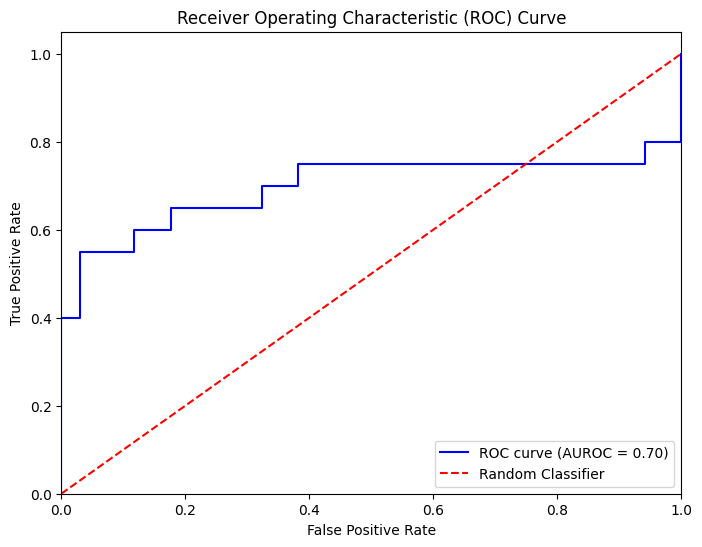

Accuracy: 0.7222
AUROC: 0.6985
Recall for class 0: 1.0000
Recall for class 1: 0.2500
Saving model..


(Pipeline(steps=[('scaler', StandardScaler()),
                 ('classifier', LogisticRegression(C=0.001, random_state=42))]),
 0.7222222222222222,
 0.6985294117647058)

In [6]:
X, y = prepare_data(base_folder="../data/train/jpg/")
train_logistic_regression(X = X, y = y)

__Prediction on new jpg files__

These confocal images returned from the _unstack.ipynb_ pipeline. 

In [7]:
tests = []

test_folder = "../data/test/jpg/"
filenames = []
for tif in os.listdir(test_folder):
    if tif.lower().endswith(('.jpg', '.jpeg')):
        test = process_image(test_folder + tif, target_size=TARGET_SIZE, normalize=True)
        filenames.append(tif)
        tests.append(test)
        
preds = predict_logistic_regression(X = tests, model_path='logistic_regression_model_{:.6f}.joblib'.format(C))
results = pd.DataFrame({'filename': filenames, 'pred_class': preds[0], 'prob': preds[1]})
results.to_csv(f"../results/logreg_predictions_{C}.tsv")
print(results)

../data/test/jpg/B02_t0_PGL_s12_channel3.jpg
../data/test/jpg/B02_t0_PGL_s30_channel3.jpg
../data/test/jpg/B04_t0_PGL_s00_channel3.jpg
../data/test/jpg/B04_t0_PGL_s15_channel3.jpg
../data/test/jpg/B04_t0_PGL_s16_channel3.jpg
../data/test/jpg/B04_t0_PGL_s27_channel3.jpg
../data/test/jpg/B04_t0_PGL_s35_channel3.jpg
../data/test/jpg/C02_t0_PXGL_s05_channel3.jpg
../data/test/jpg/C02_t0_PXGL_s17_channel3.jpg
../data/test/jpg/C02_t0_PXGL_s26_channel3.jpg
../data/test/jpg/C02_t0_PXGL_s32_channel3.jpg
../data/test/jpg/C02_t0_PXGL_s44_channel3.jpg
../data/test/jpg/C04_t0_PXGL_s05_channel3.jpg
../data/test/jpg/C04_t0_PXGL_s10_channel3.jpg
../data/test/jpg/C04_t0_PXGL_s21_channel3.jpg
../data/test/jpg/C04_t0_PXGL_s40_channel3.jpg
../data/test/jpg/C04_t0_PXGL_s48_channel3.jpg
../data/test/jpg/C07_t7_PXGL_s41_channel3.jpg
../data/test/jpg/C07_t7_PXGL_s48_channel3.jpg
../data/test/jpg/C09_t7_PXGL_s23_channel3.jpg
../data/test/jpg/C09_t7_PXGL_s29_channel3.jpg
../data/test/jpg/C09_t7_PXGL_s31_channel3

C:\Users\hetey\AppData\Local\R\cache\R\basilisk\112~1.1\0\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\hetey\AppData\Local\R\cache\R\basilisk\112~1.1\0\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hetey\AppData\Local\R\cache\R\basilisk\112~1.1\0\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hetey\AppData\Local\R\cache\R\basilisk\112~1.1\0\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hetey\AppData\Local\R\cache\R\basilisk\112~1.1\0\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rc